In [47]:
"""
chapter 7
"""

# import libs 

from scipy.misc import comb
from itertools import product 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import math

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc, accuracy_score 

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier 

from MajorityVoteClassifier import MajorityVoteClassifier


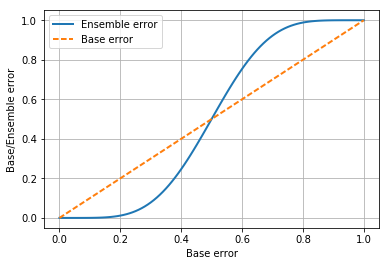

In [4]:
# why ensemble classifier is better 
# compute the ensemble error rates for a range of different base errors from 0.0 to 1.0 

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * 
             error**k * 
             (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)


error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# the error probability of an ensemble is always 
# better than the error of an individual base classifier as long as 
# the base classifiers perform better than random guessing (0.5)

In [26]:
# -------------- majority vote classifier ----------------------
# combine different classification algorithms associated 
# with individual weights for confidence

# build a stronger meta-classifier that balances out the individual classifiers' 
# weaknesses on a particular dataset

# test the MajorityVoteClassifier class 
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]  # use two features, only classify two classes
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


# individual classifier performance 
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0) # decisionTree does not need standardization
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
all_clf = [pipe1, clf2, pipe3]
# print('individual classifier performance \n10-fold cross validation:\n')

# for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
#     print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    
# majority rule voting 
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf += [mv_clf]
# print('\nmajority voting: \n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))
    
    

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


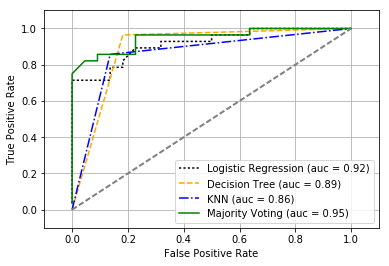

In [18]:
# evaluating and tuning the ensemble classifier 
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

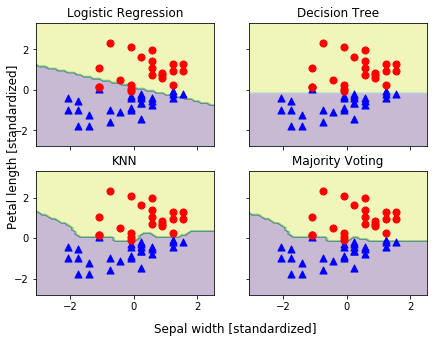

In [22]:
# standardize the training set for visual purpose 
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)   
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

# decision regions of the ensemble classifier 
# seem to be a hybrid of the decision regions from the individual classifiers. 

In [27]:
# tune the individual classifier parameters for ensemble classification

# access the individual parameters 
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [38]:
# tune the inverse regularization parameter C of the logistic regression classifier 
# and the decision tree depth via a grid search  

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

# print the different hyperparameter value combinations and 
# the average ROC AUC scores computed via 10-fold cross-validation

# deprecated !!!
# for params, mean_score, scores in grid.grid_scores_:
#     print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))

# use cv_results_ instead of grid_scores_ !!!
# for p in grid.cv_results_:
#     print(p)
    
params = grid.cv_results_['params']    
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']


# print the different hyperparameter value combinations 
# and the average ROC AUC scores computed via 10-fold cross-validation
print('average ROC with different hyperparameter value via 10-fold cross-validation:')
for par, m_s, s_s in zip(params, mean_score, std_score):
    print("%0.3f+/-%0.2f %r" % (m_s, s_s / 2, par))
    
print('best parameters %s' % grid.best_params_)    
print('best score (accuracy): %.2f' % grid.best_score_)

average ROC with different hyperparameter value via 10-fold cross-validation:
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
best parameters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
best score (accuracy): 1.00


In [43]:
# ------------------- bagging ---------------------------


# import the Wine dataset 
# only consider the Wine classes 2 and 3, and select two features: Alcohol and Hue
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash', 
                   'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 
                   'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

# encode the class labels into binary format and split the dataset into  
# 60 percent training and 40 percent test set, respectively
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

# bagging
# use an unpruned decision tree as the base classifier 
# and create an ensemble of 500 decision trees fitted 
# on different bootstrap samples of the training dataset
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,  # create an ensemble of 500 decision trees
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)


# accuracy score of the prediction on the training and test dataset 
# bagging classifier V.S. single unpruned decision tree

# a single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# bagging 
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

# the bagging classifier has a slightly better generalization performance as estimated on the test set.

Decision tree train/test accuracies 1.000/0.854
Bagging train/test accuracies 1.000/0.896


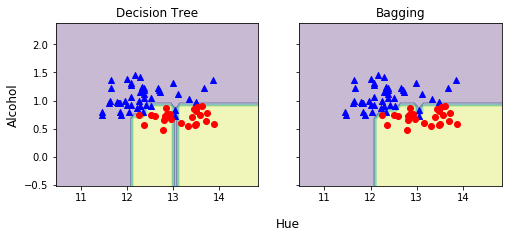

In [46]:
# compare the decision regions between the decision tree and bagging classifier
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')    
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')    
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


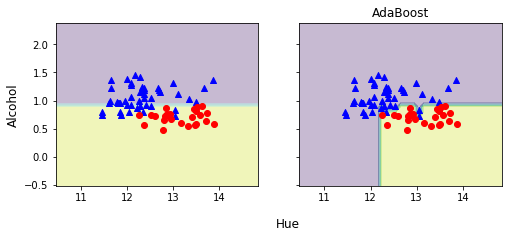

In [49]:
# -------------------------- AdaBoost -------------------------

# train the AdaBoostClassifier on 500 decision tree stumps
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

# sigle decision tree 
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# AdaBoost 
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))


# check the decision regions 
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)   
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)    
plt.show()